In [4]:
import pandas as pd
import os
import shutil

CWD = os.getcwd()

DATA_DIR = f"{CWD}/data"
TRAIN_DIR = f"{DATA_DIR}/Train"
VAL_DIR = f"{DATA_DIR}/Val"

In [5]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten
import keras.preprocessing
import utils
from PIL import Image

## Loading and processing data

In [6]:
train_datagen = keras.preprocessing.image.ImageDataGenerator()
test_dataset = keras.preprocessing.image.ImageDataGenerator()

In [7]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (128,128),
    batch_size = 32,
    class_mode = "categorical",
    color_mode = "grayscale"
)

Found 288 images belonging to 2 classes.


In [8]:
val_generator = test_dataset.flow_from_directory(
    VAL_DIR,
    target_size = (128,128),
    batch_size = 32,
    class_mode = "categorical",
    color_mode = "grayscale"
)

Found 60 images belonging to 2 classes.


## Baseline CNN

<a href="https://ibb.co/Pjcx7RL"><img src="https://i.ibb.co/MScnYbv/Screenshot-2023-05-04-at-21-58-30.png" alt="Screenshot-2023-05-04-at-21-58-30" border="0"></a>

In [9]:
baseline_model = Sequential([
    Conv2D(4, (3,3)),
    Conv2D(10, (7,7)),
    Conv2D(10, (7,7)),
    Conv2D(2, (1,1)),
    Flatten(),
    Dense(10),
    Dense(2, activation = "softmax")
])

baseline_model.compile(
    loss = keras.losses.categorical_crossentropy,
    optimizer = "adam",
    metrics = ["accuracy"])

Metal device set to: Apple M1


In [10]:
baseline_hist = baseline_model.fit(
    train_generator,
    steps_per_epoch = 8,
    epochs = 10,
    validation_data = val_generator,
    validation_steps = 2,
    verbose = 0
)

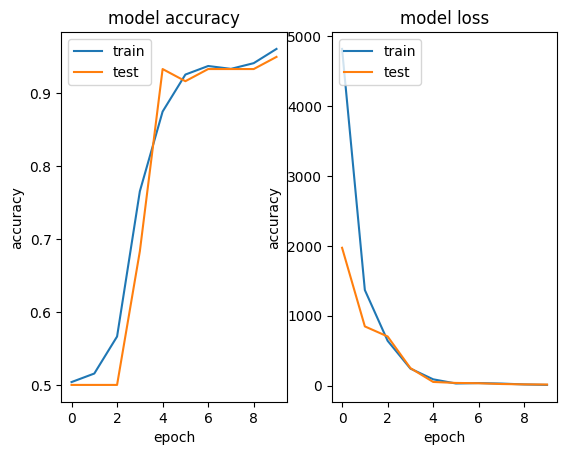

baseline model accuracy (val): 0.9500000476837158


In [11]:
utils.visualize_history(baseline_hist, name = "baseline")

## Prepare topological features

According to the paper we calculate 0-dimensional persistence diagram of the lower-star filtartion.

In [12]:
import numpy as np
from ripser import Rips
import ripser
from persim import plot_diagrams
from gtda.diagrams import BettiCurve
import math

rips = Rips()

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [13]:
batch_images_train, batch_labels_train = [], []

for _ in range(math.ceil(train_generator.samples / train_generator.batch_size)):
    data, label = train_generator.next()
    batch_images_train.extend(data)
    batch_labels_train.extend(label)

batch_images_test, batch_labels_test = [], []

for _ in range(math.ceil(val_generator.samples / val_generator.batch_size)):
    data, label = val_generator.next()
    batch_images_test.extend(data)
    batch_labels_test.extend(label)

batch_images_train = np.array(batch_images_train)
batch_labels_train = np.array(batch_labels_train)

batch_images_test = np.array(batch_images_test)
batch_labels_test = np.array(batch_labels_test)

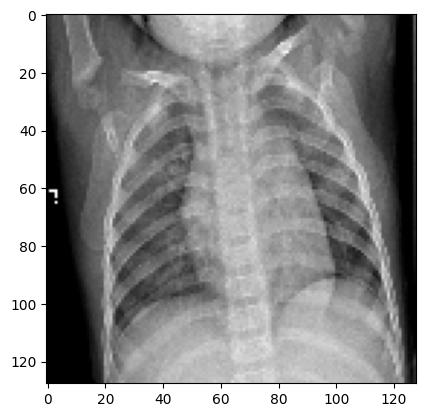

In [14]:
# The flow_from_directory method with color_mode='grayscale' returns a 3D array
vectorized_images = np.array(
    batch_images_train[:len(batch_images_train)]
    ).reshape(-1, 128, 128) / 255.0

plt.imshow(vectorized_images[0], cmap='gray')
plt.show()

In [15]:
dgms = [ripser.lower_star_img(-img) for img in vectorized_images]

Preview of an example persistence diagram.

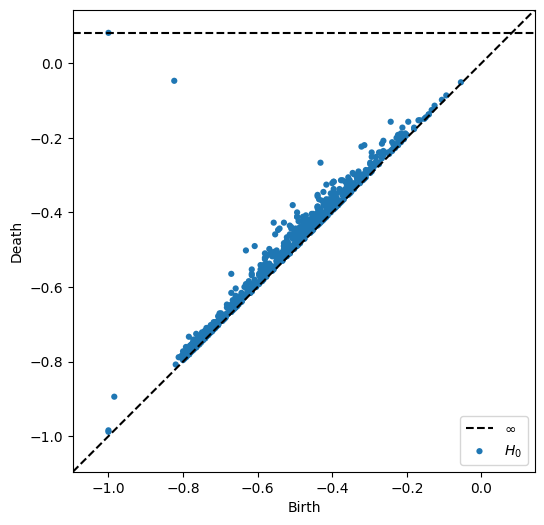

In [16]:
plt.figure(figsize=(6, 6))
plot_diagrams(dgms[11], lifetime=False)
plt.show()

I remove homologies that never die ($death \rightarrow inf$). Without that I can not calculate betti-curve as it calculates $y = y * step$ at one point.

In [17]:
# change a format to fit into package that calculates betti-curve

dgms_processed = [
    [[(pt[0], pt[1], 0) for pt in dgm[:-1]]]
    for dgm in dgms
]

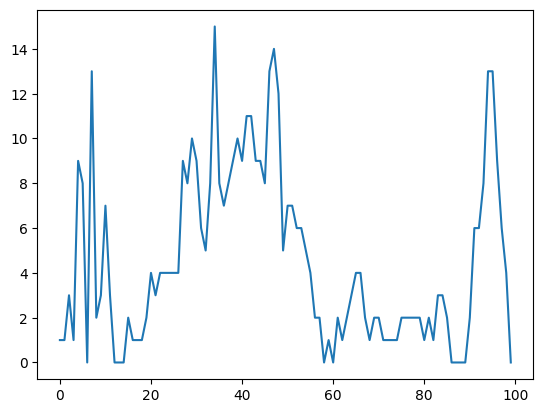

In [18]:
bc = BettiCurve() # n_bins is 100 by default

betti_curves = np.array([
    bc.fit_transform(X = dgm)[0][0]
    for dgm in dgms_processed
])

plt.plot(betti_curves[10]) # random example betti-curve
plt.show()

Above code after development was transformed into a single function to easily use it later on.

In [19]:
X_train_1st_tda_net = utils.transform_images_to_betti_curves(batch_images_train)
y_train_1st_tda_net = batch_labels_train

X_test_1st_tda_net = utils.transform_images_to_betti_curves(batch_images_test)
y_test_1st_tda_net = batch_labels_test

In [20]:
y_train_1st_tda_net.shape

(288, 2)

## 1st TDA-Net model

<a href="https://imgbb.com/"><img src="https://i.ibb.co/6XvP1t5/Screenshot-2023-05-04-at-20-46-07.png" alt="Screenshot-2023-05-04-at-20-46-07" border="0"></a>

In [21]:
first_tda_net_model = Sequential([
    Dense(300),
    Dense(600),
    Dense(200),
    Dense(200),
    Dense(2, activation = "softmax")
])

first_tda_net_model.compile(
    loss = keras.losses.categorical_crossentropy,
    optimizer = "adam",
    metrics = ["accuracy"])

first_tda_net_hist = first_tda_net_model.fit(
    x = X_train_1st_tda_net,
    y = y_train_1st_tda_net,
    steps_per_epoch = 8,
    epochs = 10,
    validation_data = (
        X_test_1st_tda_net,
        y_test_1st_tda_net
    ),
    validation_steps = 2,
    verbose = 0
    )

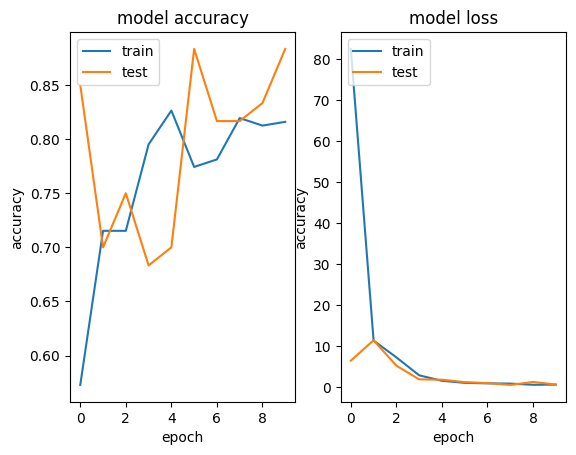

first_tda_net model accuracy (val): 0.8833333849906921


In [22]:
utils.visualize_history(first_tda_net_hist, name = "first_tda_net")

In [31]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred = (first_tda_net_model.predict(X_test_1st_tda_net) > 0.5).astype("int32")

print(precision_score(y_test_1st_tda_net, y_pred , average="macro"))

2/2 [==============================] - 0s 11ms/step
0.8872053872053872
